In [1]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit_algorithms

Note: you may need to restart the kernel to use updated packages.


In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from copy import deepcopy as copy

import qiskit
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Gate
from qiskit.circuit.library.standard_gates import UGate
from qiskit.exceptions import QiskitError
import numpy as np
from typing import List, Optional
import matplotlib.pyplot as plt
from qiskit_machine_learning import QiskitMachineLearningError
import itertools
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA, SPSA

%matplotlib inline

In [198]:
data = pd.read_csv('HI-Small_Trans.csv')

In [199]:
data

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [200]:
# Y feature: is laundering

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [202]:
data['Is Laundering'].value_counts()

Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

In [203]:
x0 = []
for i in data['Amount Received']:
    if str(i) == 'nan': x0.append(None)
    else: x0.append(i)

In [204]:
currency_dict = {
    'US Dollar':0, 'Bitcoin':1, 'Euro':2, 'Australian Dollar':3, 'Yuan':4,
    'Rupee':5, 'Mexican Peso':6, 'Yen':7, 'UK Pound':8, 'Ruble': 9,
    'Canadian Dollar':10, 'Swiss Franc':11, 'Brazil Real':12, 'Saudi Riyal':13,
    'Shekel':14
}

x1_unfiltered = list(data['Receiving Currency'])
x1 = []
for currency in x1_unfiltered:
    currency_vect = [0 for i in range(15)]
    if str(currency) != 'nan': currency_vect[currency_dict[currency]] = 1.  
    x1.append(currency_vect)

In [205]:
x2 = []
for i in data['Amount Paid']:
    if str(i) == 'nan': x2.append(None)
    else: x2.append(i)

In [206]:
payment_currency_dict = {
    'US Dollar': 0, 'Bitcoin': 1, 'Euro': 2, 'Australian Dollar': 3, 'Yuan': 4,
    'Rupee': 5, 'Yen': 6, 'Mexican Peso': 7, 'UK Pound': 8, 'Ruble': 9,
    'Canadian Dollar': 10, 'Swiss Franc': 11, 'Brazil Real': 12, 'Saudi Riyal': 13,
    'Shekel': 14
}

x3_unfiltered = list(data['Payment Currency'])
x3 = []
for currency in x3_unfiltered:
    currency_vect = [0 for i in range(15)]
    if str(currency) != 'nan':
        currency_vect[payment_currency_dict[currency]] = 1.
    x3.append(currency_vect)

In [207]:
payment_format_dict = {
    'Reinvestment': 0, 'Cheque': 1, 'Credit Card': 2, 'ACH': 3, 'Cash': 4,
    'Wire': 5, 'Bitcoin': 6
}

x4_unfiltered = list(data['Payment Format'])
x4 = []
for payment in x4_unfiltered:
    payment_vect = [0 for i in range(7)]
    if str(payment) != 'nan':
        payment_vect[payment_format_dict[payment]] = 1.
    x4.append(payment_vect)

In [208]:
x5 = []
for i in range(len(data['From Bank'])):
    if data['From Bank'].values[i] == data['To Bank'].values[i]:
        x5.append(0)
    else:
        x5.append(1.)

In [209]:
x6 = []
for i in range(len(data['Account'])):
    if data['Account'].values[i] == data['Account.1'].values[i]:
        x6.append(0)
    else:
        x6.append(1.)

In [210]:
y = []
x = []

for i, launder in enumerate(data['Is Laundering']):
    if str(launder) == "nan" or x0[i] == None or x2[i] == None: continue
    y.append(int(launder))
    x.append([x0[i]] + x1[i] + [x2[i]] + x3[i] + x4[i] + [x5[i]] + [x6[i]])

In [211]:
x = np.array(x)
y = np.array(y)

x, y = shuffle(x, y, random_state=42)

In [212]:
# Assuming x is your feature array and y is your label array
# Separate the indices of each class
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

# Randomly sample 500 indices from each class
sampled_class_0_indices = np.random.choice(class_0_indices, 1000, replace=False)
sampled_class_1_indices = np.random.choice(class_1_indices, 500, replace=False)

# Combine the sampled indices
sampled_indices = np.concatenate([sampled_class_0_indices, sampled_class_1_indices])

# Create the new x and y arrays with the sampled data points
x = x[sampled_indices]
y = y[sampled_indices]

y = [-1 if j == 0 else j for j in y]

In [213]:
x = np.array(x)
y = np.array(y)

x, y = shuffle(x, y, random_state=42)

In [214]:
sample_train, sample_test, label_train, label_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Reduce dimensions
n_dim = 32
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print(sample_train[0])

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

print(sample_train[0])

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

print(sample_train[0])

[-5.41777870e+06 -1.97996455e+05  1.04772691e+00 -6.96965030e-01
  6.01769399e-01 -2.77910275e-01 -8.40111936e-02  4.90610947e-02
  4.68862988e-02 -1.91870511e-02 -2.24492612e-02 -3.38027083e-02
 -3.99864862e-03 -3.69989929e-03  5.69140390e-03  6.45776085e-03
  8.16943612e-03  1.58539534e-03 -2.63811031e-03 -9.77453645e-03
 -2.99396780e-03 -3.34803187e-02 -9.27500017e-04  6.51265610e-03
 -7.11640017e-04  4.85678877e-04  4.24516431e-04  2.54914186e-05
 -1.66374477e-05  3.70700689e-04 -6.31041328e-10  2.81829762e-11]
[-6.68839788e-02 -2.17343900e-02  1.38053966e+00 -1.23147282e+00
  1.16008606e+00 -5.86962858e-01 -1.95974660e-01  1.49820582e-01
  1.50020184e-01 -6.56400311e-02 -8.05638059e-02 -1.23186687e-01
 -1.52308031e-02 -1.47713891e-02  2.33636887e-02  2.82809773e-02
  3.70140172e-02  7.32298968e-03 -1.30474126e-02 -5.71207001e-02
 -2.06944751e-02 -2.66408500e-01 -9.96956972e-03  8.28157219e-02
 -1.62219013e-02  1.73878168e-02  1.78425650e-02  1.25384148e-03
 -8.19085479e-04  2.0342

In [215]:
# Amplitude Embedding

"""Prepare a quantum state from the state where all qubits are 0."""

from typing import Union, Optional

import math
import numpy as np

from qiskit.exceptions import QiskitError
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.circuit.gate import Gate
from qiskit.circuit.library.standard_gates.x import CXGate, XGate
from qiskit.circuit.library.standard_gates.h import HGate
from qiskit.circuit.library.standard_gates.s import SGate, SdgGate
from qiskit.circuit.library.standard_gates.ry import RYGate
from qiskit.circuit.library.standard_gates.rz import RZGate
from qiskit.circuit.exceptions import CircuitError
from qiskit.quantum_info import Statevector

_EPS = 1e-10  # global variable used to chop very small numbers to zero


class AnglePreparation(Gate):
    """Complex amplitude state preparation.

    Class that implements the (complex amplitude) state preparation of some
    flexible collection of qubit registers.
    """
    
    # global angle_collection
    angle_collection = []
    
    def __init__(
        self,
        params: Union[str, list, int, Statevector],
        num_qubits: Optional[int] = None,
        inverse: bool = False,
        label: Optional[str] = None,
    ):
        r"""
        Args:
            params:
                * Statevector: Statevector to initialize to.
                * list: vector of complex amplitudes to initialize to.
                * string: labels of basis states of the Pauli eigenstates Z, X, Y. See
                  :meth:`.Statevector.from_label`.
                  Notice the order of the labels is reversed with respect to the qubit index to
                  be applied to. Example label '01' initializes the qubit zero to :math:`|1\rangle`
                  and the qubit one to :math:`|0\rangle`.
                * int: an integer that is used as a bitmap indicating which qubits to initialize
                  to :math:`|1\rangle`. Example: setting params to 5 would initialize qubit 0 and qubit 2
                  to :math:`|1\rangle` and qubit 1 to :math:`|0\rangle`.
            num_qubits: This parameter is only used if params is an int. Indicates the total
                number of qubits in the `initialize` call. Example: `initialize` covers 5 qubits
                and params is 3. This allows qubits 0 and 1 to be initialized to :math:`|1\rangle`
                and the remaining 3 qubits to be initialized to :math:`|0\rangle`.
            inverse: if True, the inverse state is constructed.
            label: An optional label for the gate

        Raises:
            QiskitError: ``num_qubits`` parameter used when ``params`` is not an integer

        When a Statevector argument is passed the state is prepared using a recursive
        initialization algorithm, including optimizations, from [1], as well
        as some additional optimizations including removing zero rotations and double cnots.

        **References:**
        [1] Shende, Bullock, Markov. Synthesis of Quantum Logic Circuits (2004)
        [`https://arxiv.org/abs/quant-ph/0406176v5`]

        """
        self._params_arg = params
        self._inverse = inverse
        self._name = "state_preparation_dg" if self._inverse else "state_preparation"

        if label is None:
            self._label = "State Preparation Dg" if self._inverse else "State Preparation"
        else:
            self._label = f"{label} Dg" if self._inverse else label

        if isinstance(params, Statevector):
            params = params.data

        if not isinstance(params, int) and num_qubits is not None:
            raise QiskitError(
                "The num_qubits parameter to StatePreparation should only be"
                " used when params is an integer"
            )
        self._from_label = isinstance(params, str)
        self._from_int = isinstance(params, int)

        num_qubits = self._get_num_qubits(num_qubits, params)

        params = [params] if isinstance(params, int) else params

        super().__init__(self._name, num_qubits, params, label=self._label)
        
    def _get_num_qubits(self, num_qubits, params):
        """Get number of qubits needed for state preparation"""
        if isinstance(params, str):
            num_qubits = len(params)
        elif isinstance(params, int):
            if num_qubits is None:
                num_qubits = int(math.log2(params)) + 1
        else:
            num_qubits = math.log2(len(params))

            # Check if param is a power of 2
            if num_qubits == 0 or not num_qubits.is_integer():
                raise QiskitError("Desired statevector length not a positive power of 2.")

            # Check if probabilities (amplitudes squared) sum to 1
            if not math.isclose(sum(np.absolute(params) ** 2), 1.0, abs_tol=_EPS):
                raise QiskitError("Sum of amplitudes-squared does not equal one.")

            num_qubits = int(num_qubits)
        return num_qubits

    def _gates_to_uncompute(self):
        """Call to create a circuit with gates that take the desired vector to zero.

        Returns:
            QuantumCircuit: circuit to take self.params vector to :math:`|{00\\ldots0}\\rangle`
        """

        q = QuantumRegister(self.num_qubits)
        circuit = QuantumCircuit(q, name="disentangler")
        
        # kick start the peeling loop, and disentangle one-by-one from LSB to MSB
        remaining_param = self.params

        for i in range(self.num_qubits):
            # work out which rotations must be done to disentangle the LSB
            # qubit (we peel away one qubit at a time)
            (remaining_param, thetas, phis) = AnglePreparation._rotations_to_disentangle(
                remaining_param
            )

            # perform the required rotations to decouple the LSB qubit (so that
            # it can be "factored" out, leaving a shorter amplitude vector to peel away)

            add_last_cnot = True
            if np.linalg.norm(phis) != 0 and np.linalg.norm(thetas) != 0:
                add_last_cnot = False

            if np.linalg.norm(phis) != 0:
                rz_mult = self._multiplex(RZGate, phis, last_cnot=add_last_cnot)
                if len(phis) == 1:
                    angle_collection.append(phis)

            if np.linalg.norm(thetas) != 0:
                ry_mult = self._multiplex(RYGate, thetas, last_cnot=add_last_cnot)
                if len(thetas) == 1:
                    angle_collection.append(thetas)
        circuit.global_phase -= np.angle(sum(remaining_param))
        return circuit

    @staticmethod
    def _rotations_to_disentangle(local_param):
        """
        Static internal method to work out Ry and Rz rotation angles used
        to disentangle the LSB qubit.
        These rotations make up the block diagonal matrix U (i.e. multiplexor)
        that disentangles the LSB.

        [[Ry(theta_1).Rz(phi_1)  0   .   .   0],
        [0         Ry(theta_2).Rz(phi_2) .  0],
                                    .
                                        .
        0         0           Ry(theta_2^n).Rz(phi_2^n)]]
        """
        remaining_vector = []
        thetas = []
        phis = []

        param_len = len(local_param)

        for i in range(param_len // 2):
            # Ry and Rz rotations to move bloch vector from 0 to "imaginary"
            # qubit
            # (imagine a qubit state signified by the amplitudes at index 2*i
            # and 2*(i+1), corresponding to the select qubits of the
            # multiplexor being in state |i>)
            (remains, add_theta, add_phi) = AnglePreparation._bloch_angles(
                local_param[2 * i : 2 * (i + 1)]
            )
            
            remaining_vector.append(remains)

            # rotations for all imaginary qubits of the full vector
            # to move from where it is to zero, hence the negative sign
            thetas.append(-add_theta)
            phis.append(-add_phi)

        return remaining_vector, thetas, phis

    @staticmethod
    def _bloch_angles(pair_of_complex):
        """
        Static internal method to work out rotation to create the passed-in
        qubit from the zero vector.
        """
        [a_complex, b_complex] = pair_of_complex
        # Force a and b to be complex, as otherwise numpy.angle might fail.
        a_complex = complex(a_complex)
        b_complex = complex(b_complex)
        mag_a = abs(a_complex)
        final_r = np.sqrt(mag_a**2 + np.absolute(b_complex) ** 2)
        if final_r < _EPS:
            theta = 0
            phi = 0
            final_r = 0
            final_t = 0
        else:
            theta = 2 * np.arccos(mag_a / final_r)
            a_arg = np.angle(a_complex)
            b_arg = np.angle(b_complex)
            final_t = a_arg + b_arg
            phi = b_arg - a_arg

        return final_r * np.exp(1.0j * final_t / 2), theta, phi

    def _multiplex(self, target_gate, list_of_angles, last_cnot=True):

        list_len = len(list_of_angles)
        local_num_qubits = int(math.log2(list_len)) + 1

        q = QuantumRegister(local_num_qubits)
        circuit = QuantumCircuit(q, name="multiplex" + str(local_num_qubits))

        # case of no multiplexing: base case for recursion
        if local_num_qubits == 1:
            return circuit

        # calc angle weights, assuming recursion (that is the lower-level
        # requested angles have been correctly implemented by recursion
        angle_weight = np.kron([[0.5, 0.5], [0.5, -0.5]], np.identity(2 ** (local_num_qubits - 2)))

        # calc the combo angles
        list_of_angles = angle_weight.dot(np.array(list_of_angles)).tolist()

        # recursive step on half the angles fulfilling the above assumption
        multiplex_1 = self._multiplex(target_gate, list_of_angles[0 : (list_len // 2)], False)
        if len(list_of_angles[0 : (list_len // 2)]) == 1:
            angle_collection.append(list_of_angles)

        # implement extra efficiency from the paper of cancelling adjacent
        # CNOTs (by leaving out last CNOT and reversing (NOT inverting) the
        # second lower-level multiplex)
        multiplex_2 = self._multiplex(target_gate, list_of_angles[(list_len // 2) :], False)

        return circuit

In [216]:
def normalize(vector):
    v_hat = vector / np.linalg.norm(vector)
    return v_hat

def angle_manipulation(featuremap_angles):
  for i in range(len(featuremap_angles)-1):
        featuremap_angles[i] = -1 * featuremap_angles[i]
  featuremap_angles[len(featuremap_angles)-1] = -1 * featuremap_angles[len(featuremap_angles)-1]
  if len(featuremap_angles) == 62: # CHECK
    for i in range(22):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 61: # CHECK
    featuremap_angles.insert(60, 0.0)
    for i in range(22):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 60: # CHECK
    for i in range(2):
      featuremap_angles.insert(56, 0.0)
    for i in range(22):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 59: # CHECK
    for i in range(2):
      featuremap_angles.insert(56, 0.0)
    featuremap_angles.insert(60, 0.0)
    for i in range(22):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 58: # CHECK
    for i in range(4):
      featuremap_angles.insert(48, 0.0)
    for i in range(2):
      featuremap_angles.append(0.0)
    for i in range(20):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 57: # CHECK
    for i in range(4):
      featuremap_angles.insert(48, 0.0)
    featuremap_angles.insert(60, 0.0)
    for i in range(2):
      featuremap_angles.append(0.0)
    for i in range(20):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 55: # CHECK
    for i in range(4):
      featuremap_angles.insert(48, 0.0)
    for i in range(2):
      featuremap_angles.insert(56, 0.0)
    featuremap_angles.insert(60, 0.0)
    for i in range(2):
      featuremap_angles.append(0.0)
    for i in range(20):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 54: # CHECK
    for i in range(8):
      featuremap_angles.insert(32, 0.0)
    for i in range(2):
      featuremap_angles.append(np.pi)
    for i in range(6):
      featuremap_angles.append(0.0)
    for i in range(14):
      featuremap_angles.append(np.pi)
  elif len(featuremap_angles) == 51: # CHECK
    for i in range(8):
      featuremap_angles.insert(32, 0.0)
    for i in range(2):
      featuremap_angles.insert(56, 0.0)
    featuremap_angles.insert(60, 0.0)
    for i in range(2):
      featuremap_angles.append(np.pi)
    for i in range(6):
      featuremap_angles.append(0.0)
    for i in range(14):
      featuremap_angles.append(np.pi)
  return featuremap_angles

In [217]:
import itertools

final_training_list = []
final_testing_list = []

for i in range(len(sample_train)):
    angle_collection = []
    stateprep = AnglePreparation(normalize(sample_train[i]))
    stateprep._gates_to_uncompute()
    angles_collection = list(itertools.chain(*angle_collection))
    train_angles = list(angle_manipulation(angles_collection))
    final_training_list.append(train_angles)
    
for j in range(len(sample_test)):
    angle_collection = []
    stateprep = AnglePreparation(normalize(sample_test[j]))
    stateprep._gates_to_uncompute()
    angles_collection = list(itertools.chain(*angle_collection))
    test_angles = list(angle_manipulation(angles_collection))
    final_testing_list.append(test_angles)
    if len(final_testing_list[j]) != 178:
        print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [218]:
sample_train = np.array(final_training_list)
sample_test = np.array(final_testing_list)

C:\Users\tanek\anaconda3\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


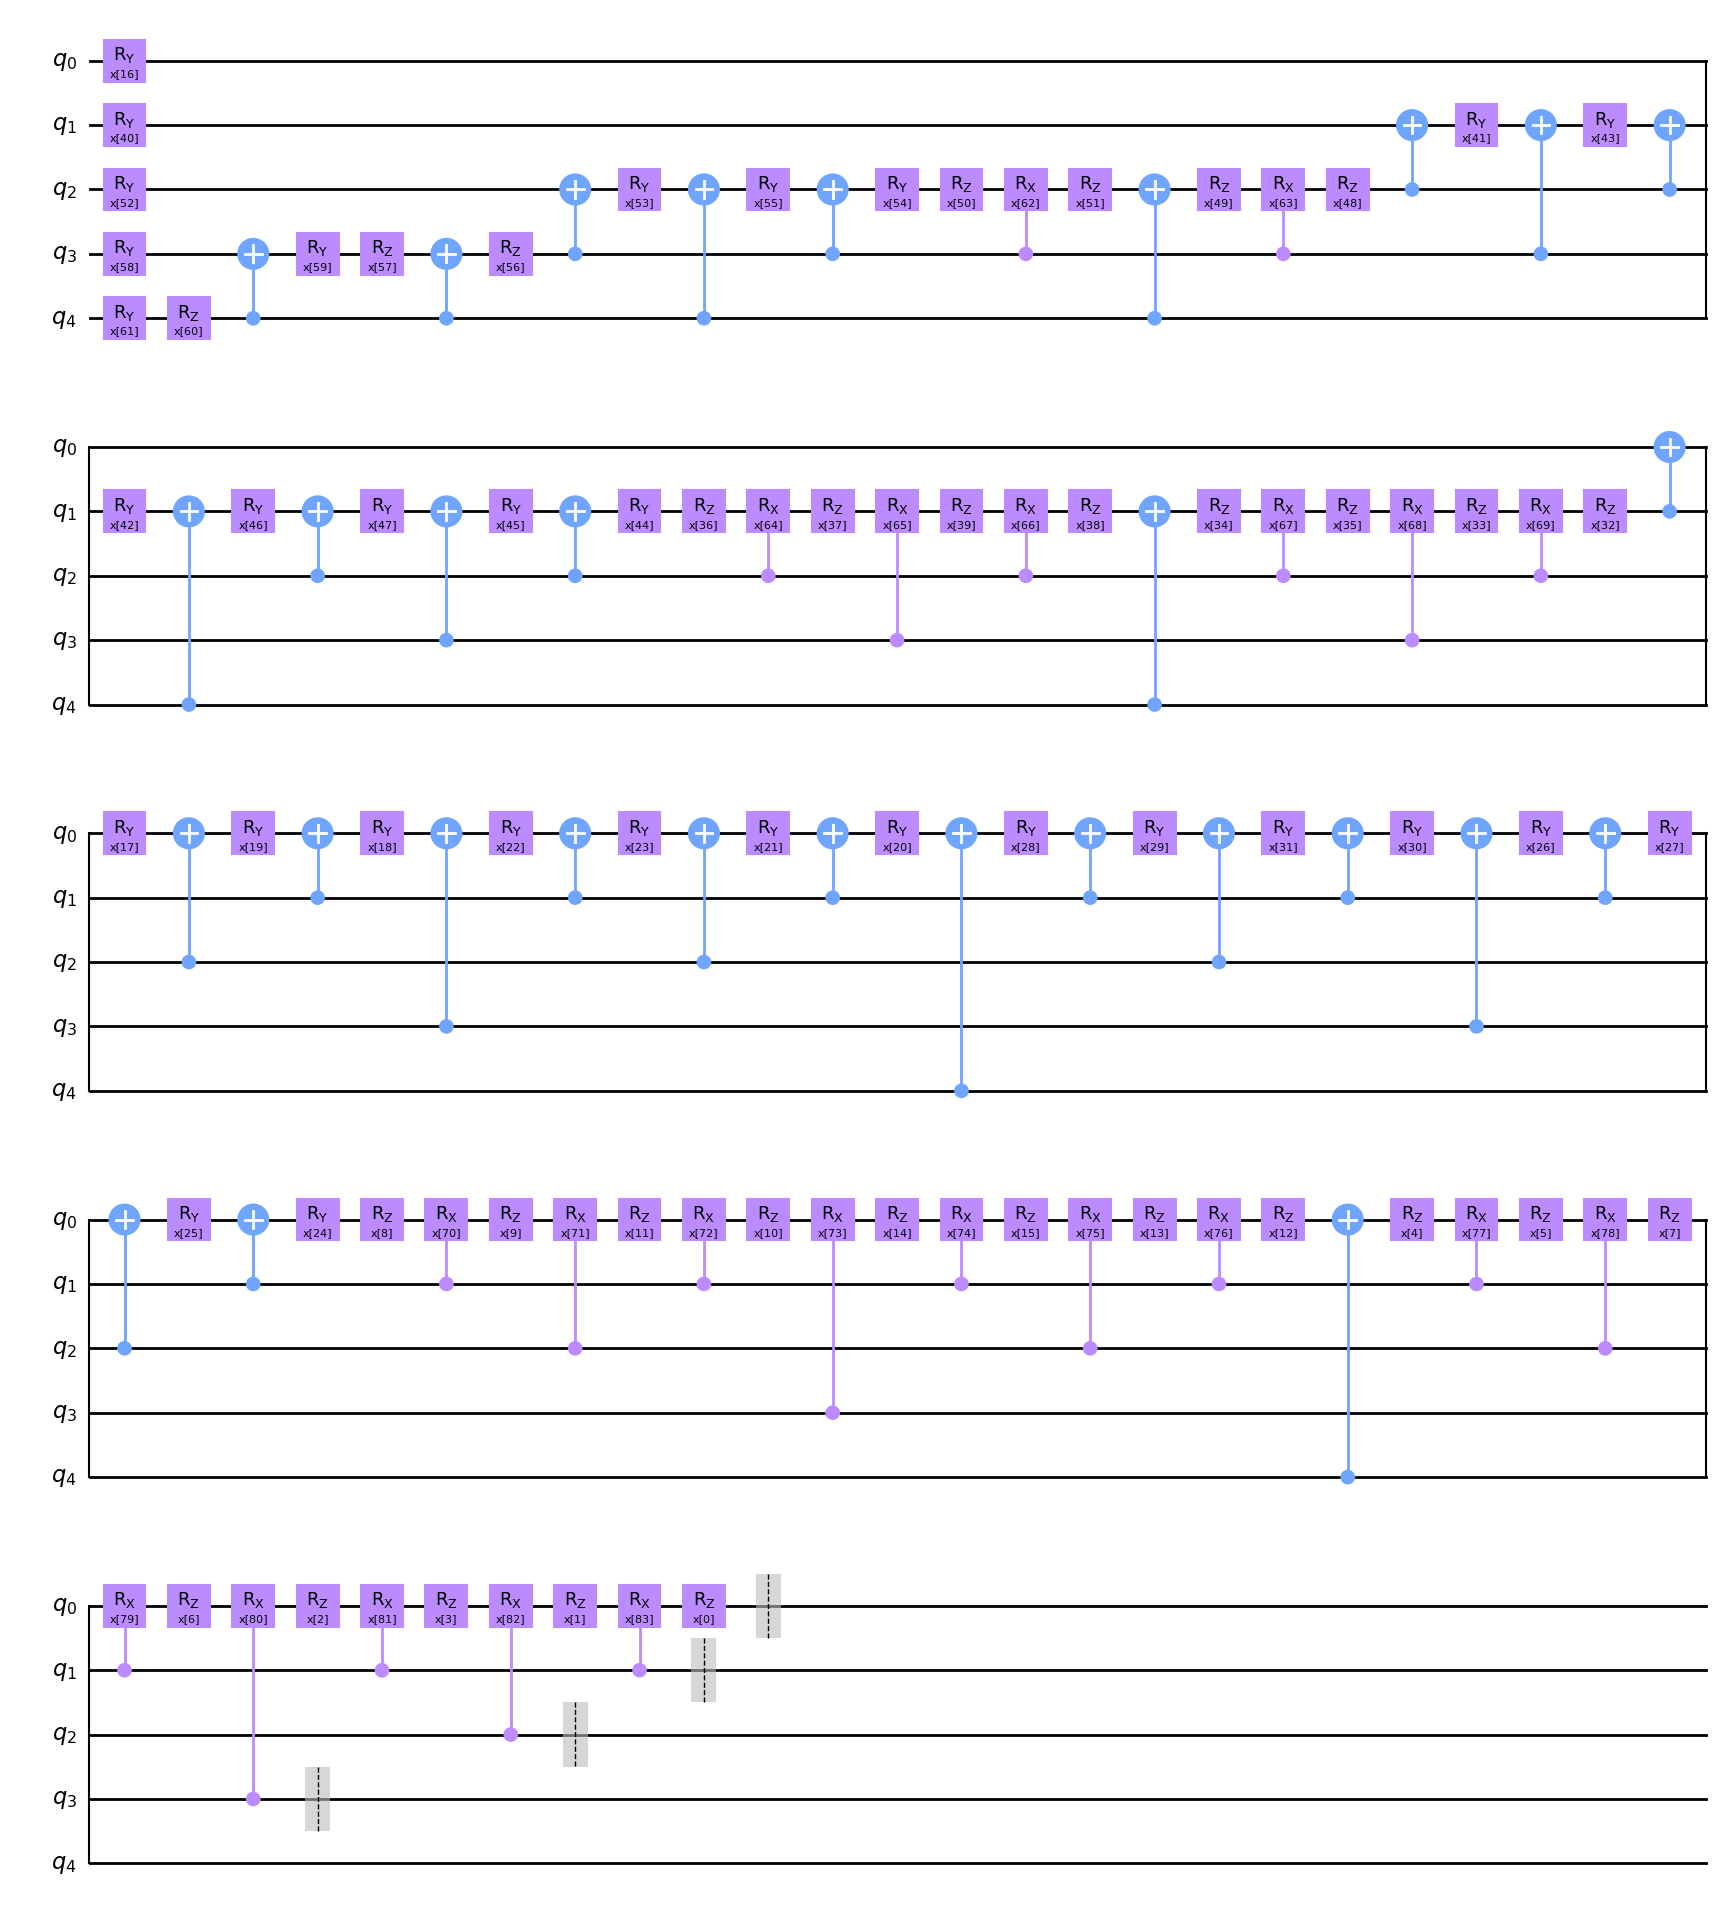

In [219]:
x = ParameterVector('x', length=84)
pauli_map = QuantumCircuit(5)
pauli_map.ry(x[16], 0)
pauli_map.ry(x[40], 1)
pauli_map.ry(x[52], 2)
pauli_map.ry(x[58], 3)
pauli_map.ry(x[61], 4)
pauli_map.rz(x[60], 4)
pauli_map.cx(4, 3)
pauli_map.ry(x[59], 3)
pauli_map.rz(x[57], 3)
pauli_map.cx(4, 3)
pauli_map.rz(x[56], 3)
pauli_map.cx(3, 2)
pauli_map.ry(x[53], 2)
pauli_map.cx(4, 2)
pauli_map.ry(x[55], 2)
pauli_map.cx(3, 2)
pauli_map.ry(x[54], 2)
pauli_map.rz(x[50], 2)
pauli_map.crx(x[62], 3, 2)
pauli_map.rz(x[51], 2)
pauli_map.cx(4, 2)
pauli_map.rz(x[49], 2)
pauli_map.crx(x[63], 3, 2)
pauli_map.rz(x[48], 2)
pauli_map.cx(2, 1)
pauli_map.ry(x[41], 1)
pauli_map.cx(3, 1)
pauli_map.ry(x[43], 1)
pauli_map.cx(2, 1)
pauli_map.ry(x[42], 1)
pauli_map.cx(4, 1)
pauli_map.ry(x[46], 1)
pauli_map.cx(2, 1)
pauli_map.ry(x[47], 1)
pauli_map.cx(3, 1)
pauli_map.ry(x[45], 1)
pauli_map.cx(2, 1)
pauli_map.ry(x[44], 1)
pauli_map.rz(x[36], 1)
pauli_map.crx(x[64], 2, 1)
pauli_map.rz(x[37], 1)
pauli_map.crx(x[65], 3, 1)
pauli_map.rz(x[39], 1)
pauli_map.crx(x[66], 2, 1)
pauli_map.rz(x[38], 1)
pauli_map.cx(4, 1)
pauli_map.rz(x[34], 1)
pauli_map.crx(x[67], 2, 1)
pauli_map.rz(x[35], 1)
pauli_map.crx(x[68], 3, 1)
pauli_map.rz(x[33], 1)
pauli_map.crx(x[69], 2, 1)
pauli_map.rz(x[32], 1)
pauli_map.cx(1, 0)
pauli_map.ry(x[17], 0)
pauli_map.cx(2, 0)
pauli_map.ry(x[19], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[18], 0)
pauli_map.cx(3, 0)
pauli_map.ry(x[22], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[23], 0)
pauli_map.cx(2, 0)
pauli_map.ry(x[21], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[20], 0)
pauli_map.cx(4, 0)
pauli_map.ry(x[28], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[29], 0)
pauli_map.cx(2, 0)
pauli_map.ry(x[31], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[30], 0)
pauli_map.cx(3, 0)
pauli_map.ry(x[26], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[27], 0)
pauli_map.cx(2, 0)
pauli_map.ry(x[25], 0)
pauli_map.cx(1, 0)
pauli_map.ry(x[24], 0)
pauli_map.rz(x[8], 0)
pauli_map.crx(x[70], 1, 0)
pauli_map.rz(x[9], 0)
pauli_map.crx(x[71], 2, 0)
pauli_map.rz(x[11], 0)
pauli_map.crx(x[72], 1, 0)
pauli_map.rz(x[10], 0)
pauli_map.crx(x[73], 3, 0)
pauli_map.rz(x[14], 0)
pauli_map.crx(x[74], 1, 0)
pauli_map.rz(x[15], 0)
pauli_map.crx(x[75], 2, 0)
pauli_map.rz(x[13], 0)
pauli_map.crx(x[76], 1, 0)
pauli_map.rz(x[12], 0)
pauli_map.cx(4, 0)
pauli_map.rz(x[4], 0)
pauli_map.crx(x[77], 1, 0)
pauli_map.rz(x[5], 0)
pauli_map.crx(x[78], 2, 0)
pauli_map.rz(x[7], 0)
pauli_map.crx(x[79], 1, 0)
pauli_map.rz(x[6], 0)
pauli_map.crx(x[80], 3, 0)
pauli_map.rz(x[2], 0)
pauli_map.crx(x[81], 1, 0)
pauli_map.rz(x[3], 0)
pauli_map.crx(x[82], 2, 0)
pauli_map.rz(x[1], 0)
pauli_map.crx(x[83], 1, 0)
pauli_map.rz(x[0], 0)
for i in range(4):
    pauli_map.barrier(i)

pauli_map.draw(output='mpl')

In [220]:
class StronglyEntanglingLayers(QuantumCircuit):
    """
    https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html
    """
    
    def __init__(
        self,
        num_qubits: int,
        entanglement: str | list[int] | list[list[int]] | None = None,
        reps: int = 1,
        parameter_prefix: str = "θ",
        skip_final_rotation_layer: bool = False,
        initial_state: QuantumCircuit | None = None,
        name: str | None = "nlocal",
    ):

        super().__init__(num_qubits, name=name)
        self.reps = reps
        self.parameter_prefix = parameter_prefix
        self.skip_final_rotation_layer = skip_final_rotation_layer
        self.initial_state = initial_state
        self.entanglement = entanglement

        num_parameters = (3 * num_qubits * reps) + (3 * num_qubits if not skip_final_rotation_layer else 0)
        self.param_vector = ParameterVector(parameter_prefix, length=num_parameters)

        self.build()

    def build(self):
        if self.initial_state:
            self.compose(self.initial_state, inplace=True)

        param_idx = 0

        for _ in range(self.reps):
            # Apply expanded U Gate
            for qubit in range(self.num_qubits):
                self.rx(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.ry(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.rz(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.barrier(qubit)

            self.apply_entanglement()

            self.barrier()

        if not self.skip_final_rotation_layer:
            for qubit in range(self.num_qubits):
                self.rx(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.ry(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.rz(self.param_vector[param_idx], qubit)
                param_idx += 1
                self.barrier(qubit) # barrier for visibility

    def apply_entanglement(self):
        entanglement_map = self.get_entangler_map(self.entanglement)

        for pair in entanglement_map:
            self.cx(pair[0], pair[1])

    def get_entangler_map(self, entanglement):
        n = self.num_qubits
        m = 2 # 2-qubit entanglement

        if entanglement == "full":
            return list(itertools.combinations(list(range(n)), m))
        elif entanglement == "reverse_linear":
            reverse = [tuple(range(n - i - m, n - i)) for i in range(n - m + 1)]
            return reverse
        elif entanglement in ["linear", "circular", "sca", "pairwise"]:
            linear = [tuple(range(i, i + m)) for i in range(n - m + 1)]
            if entanglement == "linear" or m == 1:
                return linear

            if entanglement == "pairwise":
                return linear[::2] + linear[1::2]
            
            if n > m:
                circular = [tuple(range(n - m + 1, n)) + (0,)] + linear # circular is linear plus top-bottom entanglement 
                                                                        # given space
            else:
                circular = linear
            if entanglement == "circular":
                return circular

            shifted = circular[-1:] + circular[:-1] # SCA is circular plus shift and reverse
            return shifted

        else:
    
            return entanglement # custom list of indices

In [221]:
class qMe(QuantumCircuit):
    """
    A flexible class that dynamically selects and combines embedding and ansatz layers into a single QuantumCircuit.
    """

    def __init__(
        self,
        num_qubits: int,
        embedding: str = None,
        ansatz: str = None,
        gate_sequence: Optional[List[str]] = None,
        repeat_parameters: Optional[bool] = False,
        entanglement: Optional[str] = "full",
        amplitude: Optional[bool] = True,
        n_layers: Optional[int] = 1,
    ):
        # Initialize the superclass with the specified number of qubits
        super().__init__(num_qubits)

        # Store parameters using a different attribute name to avoid conflicts
        self._num_qubits = num_qubits
        self.amplitude = amplitude
        self.n_layers = n_layers
        self.entanglement = entanglement
        self.gate_sequence = gate_sequence if gate_sequence else []
        self.repeat_parameters = repeat_parameters

        # Determine the feature map and ansatz circuits
        self._feature_map = self._get_embedding_circuit(embedding)
        self._ansatz = self._get_ansatz_circuit(ansatz)

        # Ensure that both circuits have the same number of qubits
        if self._feature_map.num_qubits != self._ansatz.num_qubits:
            raise QiskitMachineLearningError("Feature map and ansatz must have the same number of qubits.")

        # Compose the circuits
        self.compose(self._feature_map, inplace=True)
        self.compose(self._ansatz, inplace=True)

        # Manually set the input and weight parameters for better control
        self._input_parameters = self._feature_map.parameters
        self._weight_parameters = self._ansatz.parameters

    def _get_embedding_circuit(self, embedding: str) -> QuantumCircuit:
        # Dynamically select and instantiate the embedding circuit
        if embedding == "amplitude":
            return pauli_map
        else:
            raise QiskitMachineLearningError(f"Unknown embedding type: {embedding}.")

    def _get_ansatz_circuit(self, ansatz: str) -> QuantumCircuit:
        # Dynamically select and instantiate the ansatz circuit
        if ansatz == "strongly_entangling_layers":
            return StronglyEntanglingLayers(num_qubits=self._num_qubits, entanglement=self.entanglement, reps=self.n_layers)
        elif ansatz == "basic_entangling_layers":
            return BasicEntanglerLayers(num_qubits=self._num_qubits, reps=self.n_layers)
        elif ansatz == "simplified_two_design":
            return SimplifiedTwoDesign(num_qubits=self._num_qubits, n_layers=self.n_layers)
        else:
            raise QiskitMachineLearningError(f"Unknown ansatz type: {ansatz}.")

    @property
    def input_parameters(self) -> ParameterVector:
        """Returns the input parameters of the feature map."""
        return self._input_parameters

    @property
    def weight_parameters(self) -> ParameterVector:
        """Returns the weight parameters of the ansatz."""
        return self._weight_parameters

    @property
    def num_input_parameters(self) -> int:
        """Returns the number of input parameters."""
        return len(self.input_parameters)

    @property
    def num_weight_parameters(self) -> int:
        """Returns the number of weight parameters."""
        return len(self.weight_parameters)

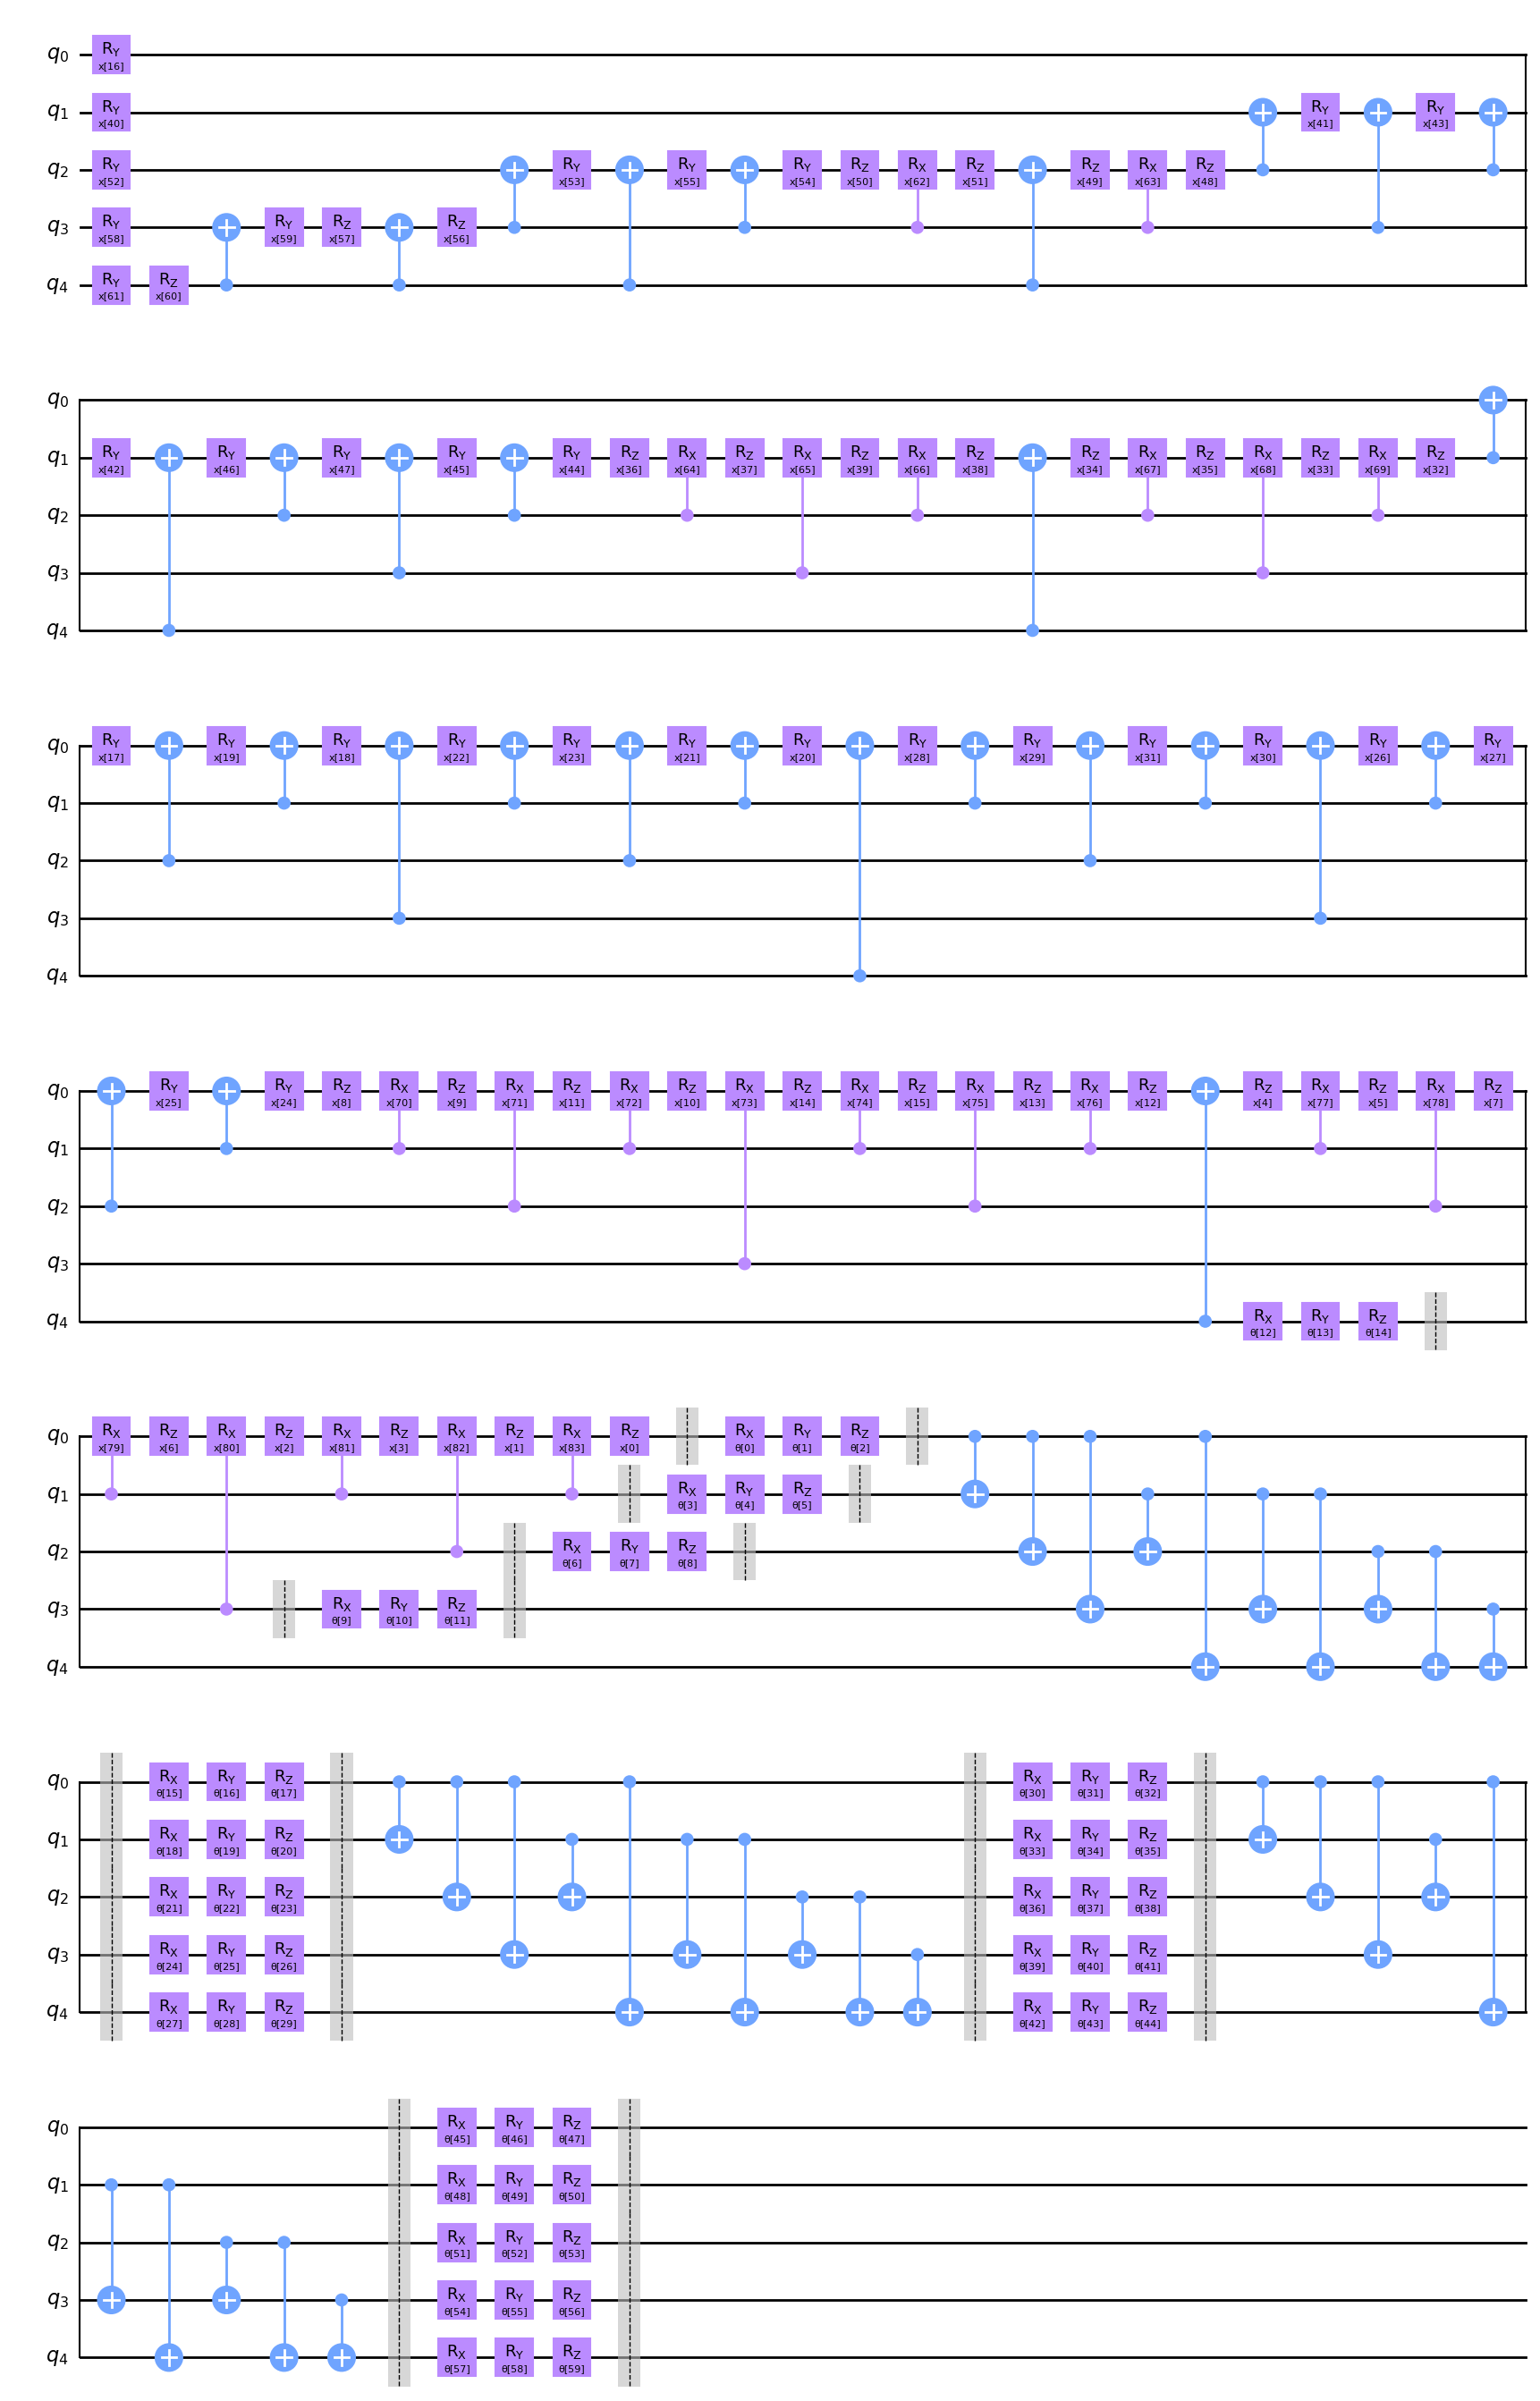

In [222]:
qc = qMe(num_qubits=5, embedding='amplitude', ansatz='strongly_entangling_layers', entanglement='full', n_layers=3)
estimator_qnn = EstimatorQNN(
    circuit=qc,
    input_params=qc.input_parameters,
    weight_params=qc.weight_parameters
)

qc.draw(output='mpl')

In [223]:
np.random.seed(42)

In [224]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [225]:
objective_func_vals = []

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=SPSA(maxiter=100, learning_rate=None, perturbation=None), callback=callback_graph
)

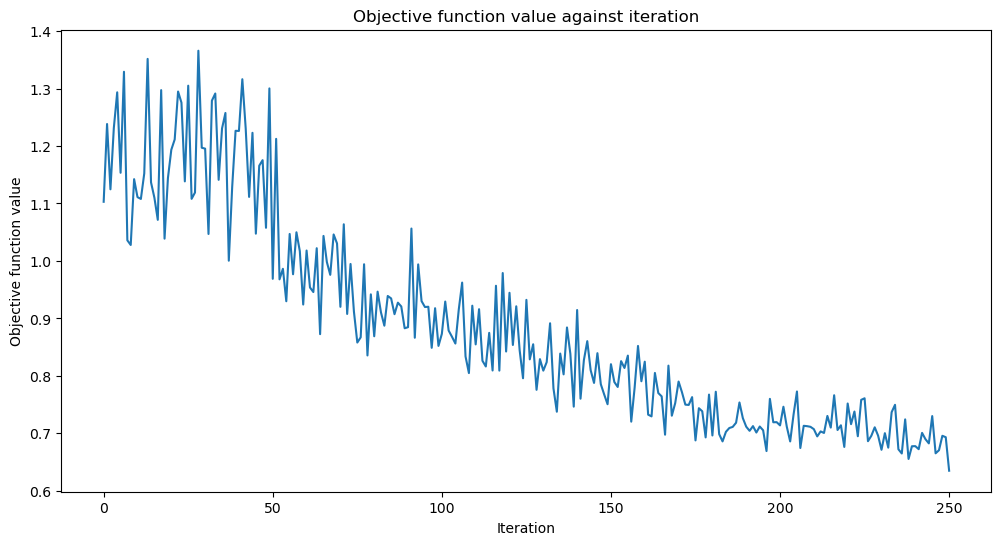

Classifier Accuracy: 80.00%


In [226]:
plt.rcParams["figure.figsize"] = (12, 6)
estimator_classifier.fit(sample_train, label_train)
plt.rcParams["figure.figsize"] = (6, 4)
score = estimator_classifier.score(sample_test, label_test)
print(f"Classifier Accuracy: {score * 100:.2f}%")